In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time
import pandas as pd
import scipy.sparse.linalg
import seaborn as sns
import warnings
import yfinance as yf
from numba import jit
import colormaps as cmaps

sns.set(palette='viridis')
warnings.filterwarnings("ignore")

import jumpdiffcalibrator as jdcal

$$S_{t+h} = S_t + \sigma S_t h  + \sqrt{V_t} S_t \sqrt{h} Z^S_{t}$$
$$S_{t+h} = V_t +κ(θ - V_t) h + \xi \sqrt{V_t} \sqrt{h} Z^V_{t}$$
<br>

$$Z^V_{t} \sim \mathcal{N}(0, 1)$$
$$Z^S_{t} \sim \mathcal{N}(0, 1)$$
$$Cov(Z^V_{t},Z^S_{t}) = ρ$$
<br>
	$$\begin{bmatrix}
  Z^S_{t} \\
  Z^V_{t}
  \end{bmatrix} =\begin{pmatrix}
\begin{bmatrix}0 \\ 0
\end{bmatrix}, \begin{bmatrix}1 & \rho  \\ \rho & 1
\end{bmatrix}
\end{pmatrix} $$
<br>
$ \mu$ = drift
<br>
$θ = avg. var. $
<br>
$κ = rate of mean reversion$
<br>
$\xi$ = vol.


[[ 1.         -0.72589157]
 [-0.72589157  1.        ]]


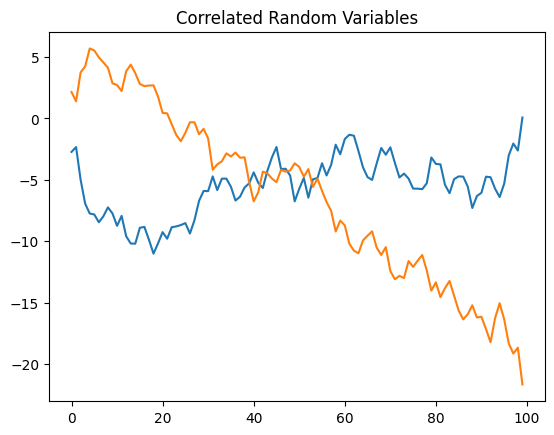

In [ ]:
rho = -0.7
number_of_iterations = 100
mu = np.array([0, 0])
covariance = np.array([[1, rho], [rho, 1]])
path = np.random.multivariate_normal(mu,covariance, number_of_iterations)
plt.plot(path.cumsum(axis=0));
plt.title('Correlated Random Variables')
print(np.corrcoef(path.T))

In [2]:
def generate_heston_model(S, T, r, kappa, theta, V_0, rho, xi, steps, number_of_iterations):
  dt = T/steps
  size = (number_of_iterations, steps)
  prices = np.zeros(size)
  sigmas = np.zeros(size)
  S_t = S
  V_t = V_0
  covariance = np.array([[1, rho], [rho, 1]])

  for i in range(steps):
    W_t = np.random.multivariate_normal(np.array([0, 0]), covariance, size=number_of_iterations)

    S_t = S_t + r * S_t * dt + np.sqrt(V_t) * S_t * np.sqrt(dt) * W_t[:, 0]
    V_t = np.abs(V_t + kappa * (theta - V_t) * dt + xi * np.sqrt(V_t) * np.sqrt(dt) * W_t[:, 1])
    prices[:,i] = S_t
    sigmas[:,i] = V_t

  return prices, sigmas

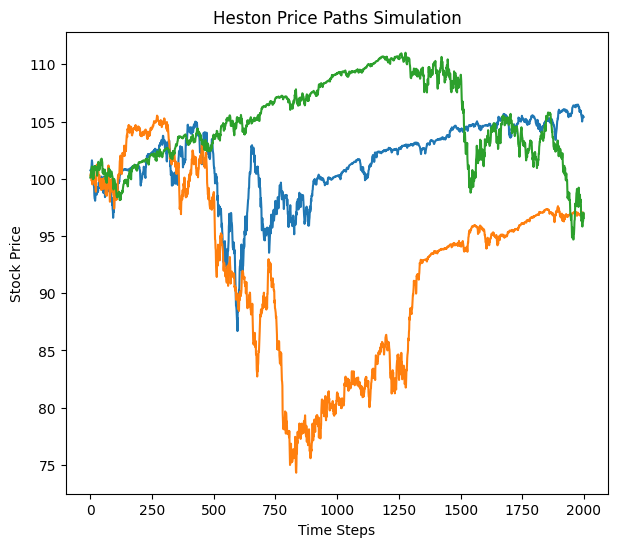

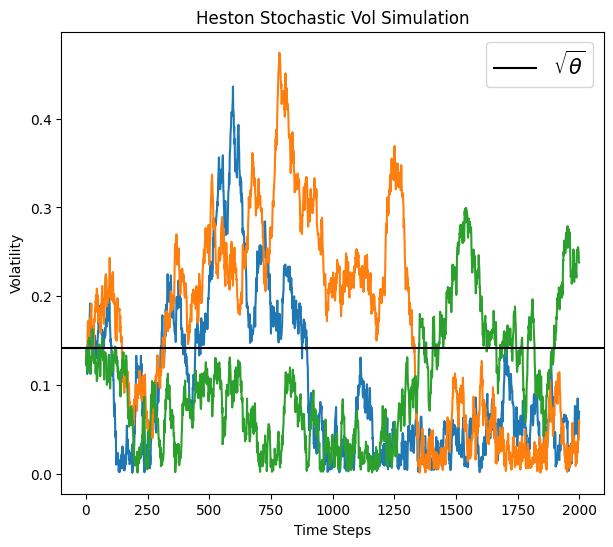

In [ ]:
kappa =4
theta = 0.02
V_0 =  0.02
xi = 0.9
r = 0.02
S = 100
paths =3
steps = 2000
T = 1
rho=-0.8
prices, sigmas = generate_heston_model(S, T, r, kappa, theta, V_0, rho, xi, steps, paths)

plt.figure(figsize=(7,6))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(7,6))
plt.plot(np.sqrt(sigmas).T)
plt.axhline(np.sqrt(theta), color='black', label=r'$\sqrt{\theta}$')
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend(fontsize=15)
plt.show()

In [27]:
ticker = "AAPL"
df = yf.download(ticker, start="2025-01-01", auto_adjust=False, progress=False)

df = df.sort_index()
stock_data = df.iloc[:,0].to_numpy().astype(float)

# ----- set parameters
s0 = 100
nsteps = 2000
nsim = 100
r = 0.05
q = 0.02
T = 1.0
K = 100




1 Failed download:
['AAPL']: Timeout('Failed to perform, curl: (28) Connection timed out after 10008 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [4]:
# ================================== Heston calibration====================================
# ----- calibrate parameters
n_mcmc_steps = 10000
burn_in = 5000
heston_cal = jdcal.HestonCalibrator(price_series=stock_data, cost_of_carry=r - q)

start = time.time()
heston_cal.calibrate(n_mcmc_steps=n_mcmc_steps, burn_in=burn_in)
finish = time.time()
print(f"{(finish-start)/60} minutes elapsed")

# ----- get the calibrated parameters
all_params = heston_cal.params_dict
mu = all_params.get("mu_final")
kappa = all_params.get("kappa_final")
theta = all_params.get("theta_final")
sigma = all_params.get("volvol_final")
rho = all_params.get("rho_final")

# ----- get stock and variance trajectories
simulated_paths, simulated_variances = heston_cal.get_paths(s0=s0, nsteps=nsteps, nsim=nsim, risk_neutral=False)

100%|██████████| 9999/9999 [01:53<00:00, 88.25it/s] 


1.8887564142545064 minutes elapsed


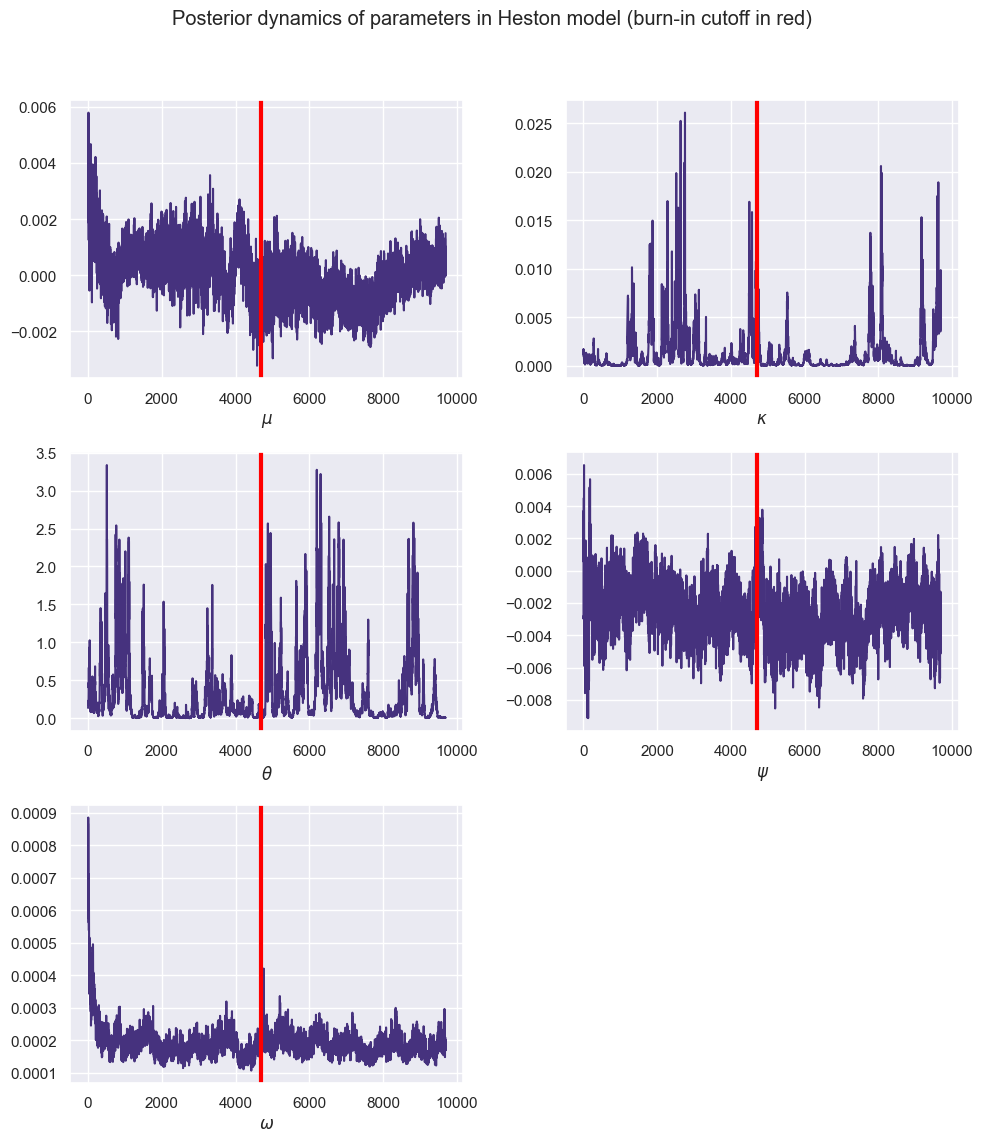

In [5]:
# ----- get the figures
# --- (a) parameters' dynamics
offset = 300
burn_in_pos = burn_in - offset
param_paths = heston_cal.all_params_array_full[offset:, :]
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes[0, 0].plot(param_paths[:, 0])
axes[0, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[0, 0].set_xlabel("$\\mu$")
axes[0, 1].plot(param_paths[:, 1])
axes[0, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[0, 1].set_xlabel("$\\kappa$")
axes[1, 0].plot(param_paths[:, 2])
axes[1, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[1, 0].set_xlabel("$\\theta$")
axes[1, 1].plot(param_paths[:, 3])
axes[1, 1].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[1, 1].set_xlabel("$\\psi$")
axes[2, 0].plot(param_paths[:, 4])
axes[2, 0].axvline(x=burn_in_pos, color="red", linewidth=3)
axes[2, 0].set_xlabel("$\\omega$")
axes[2, 1].remove()
plt.suptitle('Posterior dynamics of parameters in Heston model (burn-in cutoff in red)')
plt.subplots_adjust(wspace=None, hspace=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

[ 69.27291941  38.61168204  44.97181382  22.46219238  61.02710445
  60.25584831 100.58686267  30.55844124  41.37141485  86.39904639
  48.90717098 111.99773911 127.53608056  70.34113635 226.86068119
 279.41288227  47.21495082 103.43733086 147.56741458 148.20909868
  17.51086095 113.70064565  35.20261429 203.79625951  85.91708339
  42.96467989  93.8117907   77.69846553  20.93644521  82.64603397
  58.65008013 108.91249826  71.28252377 106.0248424  107.80311072
  37.74152288  72.31815334  24.524501   119.1615643  187.58160001
 135.10233604  57.27240488  41.34466297  48.44591389  42.74958414
  37.56059075  53.77219871  85.77963362  46.59034961 107.46606736
  85.54511986 142.50658388  75.62849271 318.99549118  62.11153544
 131.7819139   82.48383694  80.60310321 114.04892048 116.4798774
  43.17033777  50.04186017  59.75357197 107.07733316 102.51613572
  59.26118543  53.60301014 221.26196919  91.7441873   49.05614782
  19.93147025 337.86623013  37.39399795  32.39573899  75.21875757
  32.925487

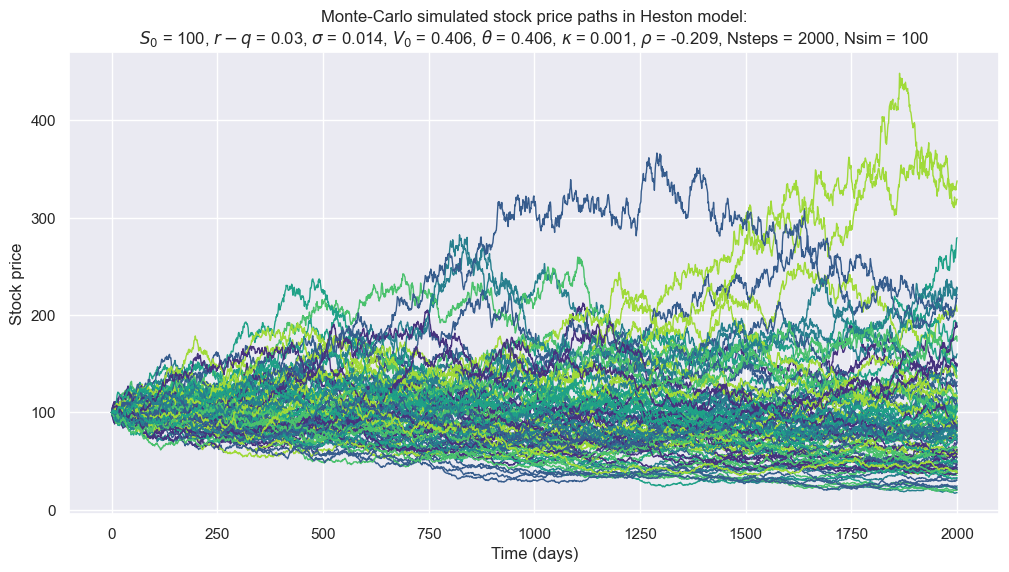

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_prices = ax.plot(days, simulated_paths.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated stock price paths in Heston model:\n$S_0$ = {}, $r-q$ = {}, "
             "$\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, "
             "Nsteps = {}, Nsim = {}".format(*list(map(lambda x: round(x, 3), [s0, r - q, np.round(sigma, 3),
                                                                               np.round(theta, 3), np.round(theta, 3),
                                                                               np.round(kappa, 3), np.round(rho, 3),
                                                                               nsteps, nsim]))))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Stock price')
plt.plot(K, color='black')

paths_list = np.array(simulated_paths.tolist())

print(paths_list[:,-1])
payoff = np.maximum(paths_list[:,-1] - K, 0)
C = np.exp(-r * T) * np.mean(payoff)
print(C)



Text(0, 0.5, 'Variance process')

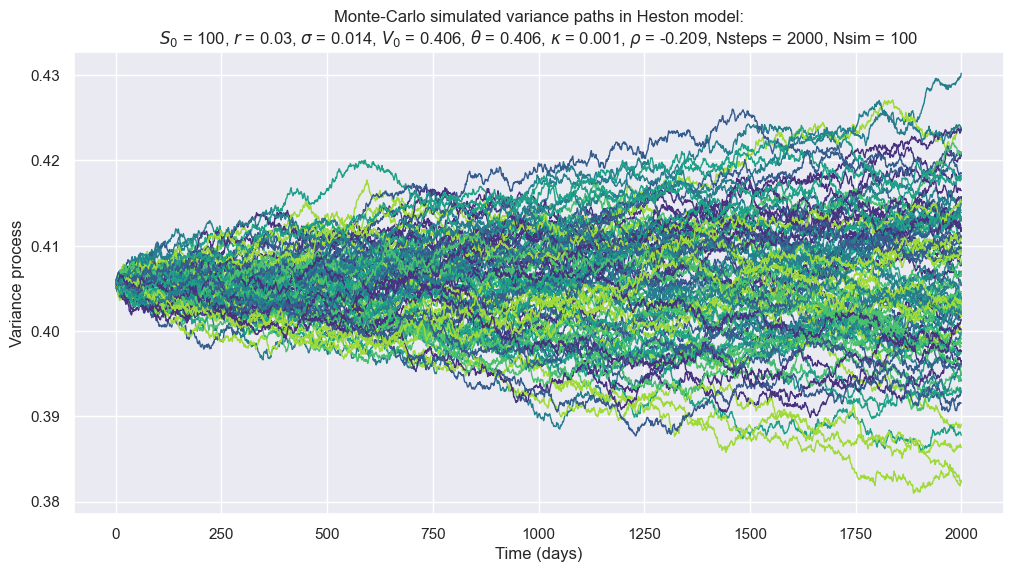

In [30]:
# --- (c) price variances
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_volas = ax.plot(days, simulated_variances.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated variance paths in Heston model:\n$S_0$ = {}, $r$ = {}, "
             "$\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, "
             "Nsteps = {}, Nsim = {}".format(*list(map(lambda x: round(x, 3), [s0, r - q, np.round(sigma, 3),
                                                                               np.round(theta, 3), np.round(theta, 3),
                                                                               np.round(kappa, 3), np.round(rho, 3),
                                                                               nsteps, nsim]))))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Variance process')

# Heston 2d pde


In [33]:
def build_derivatives_2d(NAS, NVS, ds, dv):
    N = NAS * NVS
    DS  = sp.sparse.lil_matrix((N, N))
    D2S = sp.sparse.lil_matrix((N, N))
    DV  = sp.sparse.lil_matrix((N, N))
    D2V = sp.sparse.lil_matrix((N, N))
    DSV = sp.sparse.lil_matrix((N, N))

    def idx(i, j):
        # Flattening
        return i + j * NAS

    for j in range(NVS):
        for i in range(NAS):
            k = idx(i, j)
            # First derivative S
            if 1 <= i < NAS - 1:
                DS[k, idx(i - 1, j)] = -0.5 / ds
                DS[k, idx(i + 1, j)] =  0.5 / ds
            elif i == 0:
                DS[k, idx(i, j)]     = -1.0 / ds
                DS[k, idx(i + 1, j)] =  1.0 / ds
            elif i == NAS - 1:
                DS[k, idx(i - 1, j)] = -1.0 / ds
                DS[k, idx(i, j)]     =  1.0 / ds

            # Second derivative S
            if 1 <= i < NAS - 1:
                D2S[k, idx(i - 1, j)] =  1.0 / ds**2
                D2S[k, idx(i, j)]     = -2.0 / ds**2
                D2S[k, idx(i + 1, j)] =  1.0 / ds**2
            elif i == 0:
                D2S[k, idx(i, j)]     =  1.0 / ds**2
                D2S[k, idx(i + 1, j)] = -2.0 / ds**2
                D2S[k, idx(i + 2, j)] =  1.0 / ds**2
            elif i == NAS - 1:
                D2S[k, idx(i - 2, j)] =  1.0 / ds**2
                D2S[k, idx(i - 1, j)] = -2.0 / ds**2
                D2S[k, idx(i, j)]     =  1.0 / ds**2

            # First derivative v
            if 1 <= j < NVS - 1:
                DV[k, idx(i, j - 1)] = -0.5 / dv
                DV[k, idx(i, j + 1)] =  0.5 / dv
            elif j == 0:
                DV[k, idx(i, j)]     = -1.0 / dv
                DV[k, idx(i, j + 1)] =  1.0 / dv
            elif j == NVS - 1:
                DV[k, idx(i, j - 1)] = -1.0 / dv
                DV[k, idx(i, j)]     =  1.0 / dv

            # Second derivative
            if 1 <= j < NVS - 1:
                D2V[k, idx(i, j - 1)] =  1.0 / dv**2
                D2V[k, idx(i, j)]     = -2.0 / dv**2
                D2V[k, idx(i, j + 1)] =  1.0 / dv**2
            elif j == 0:
                D2V[k, idx(i, j)]     =  1.0 / dv**2
                D2V[k, idx(i, j + 1)] = -2.0 / dv**2
                D2V[k, idx(i, j + 2)] =  1.0 / dv**2
            elif j == NVS - 1:
                D2V[k, idx(i, j - 2)] =  1.0 / dv**2
                D2V[k, idx(i, j - 1)] = -2.0 / dv**2
                D2V[k, idx(i, j)]     =  1.0 / dv**2

            # Cross derivative (central differences)
            if (1 <= i < NAS - 1) and (1 <= j < NVS - 1):

                DSV[k, idx(i - 1, j - 1)] =  1.0 / (4 * ds * dv)
                DSV[k, idx(i + 1, j + 1)] =  1.0 / (4 * ds * dv)
                DSV[k, idx(i - 1, j + 1)] = -1.0 / (4 * ds * dv)
                DSV[k, idx(i + 1, j - 1)] = -1.0 / (4 * ds * dv)

    return DS.tocsr(), D2S.tocsr(), DV.tocsr(), D2V.tocsr(), DSV.tocsr()

In [56]:
def plot_heston_simple(U_grid, S, V, title="Heston Model Option Price"):
    S_grid, V_grid = np.meshgrid(S, V, indexing="ij")

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        S_grid,
        V_grid,
        U_grid,
        cmap='viridis',  # Better colormap
        linewidth=0,
        antialiased=True,
        alpha=0.9,
        edgecolor='none'
    )

    ax.set_xlabel("Asset Price (S)", fontsize=12, labelpad=10)
    ax.set_ylabel("Volatility (V)", fontsize=12, labelpad=10)
    ax.set_zlabel("Option Value", fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    ax.view_init(elev=25, azim=45)

    plt.tight_layout()

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.41801468e-42 -6.41801468e-42  3.71008105e-40 ...  2.16630332e-07
   2.49141012e-07  2.49141012e-07]
 [ 9.02083023e-38  9.02083023e-38  4.71546125e-36 ...  1.04965103e-05
   1.18399500e-05  1.18399500e-05]
 ...
 [ 9.57184128e+01  9.57184128e+01  9.63110360e+01 ...  9.86005140e+01
   9.86075199e+01  9.86075199e+01]
 [ 9.87166570e+01  9.87166570e+01  9.90795480e+01 ...  1.00302616e+02
   1.00306218e+02  1.00306218e+02]
 [ 1.01980133e+02  1.01980133e+02  1.01980133e+02 ...  1.01980133e+02
   1.01980133e+02  1.01980133e+02]]


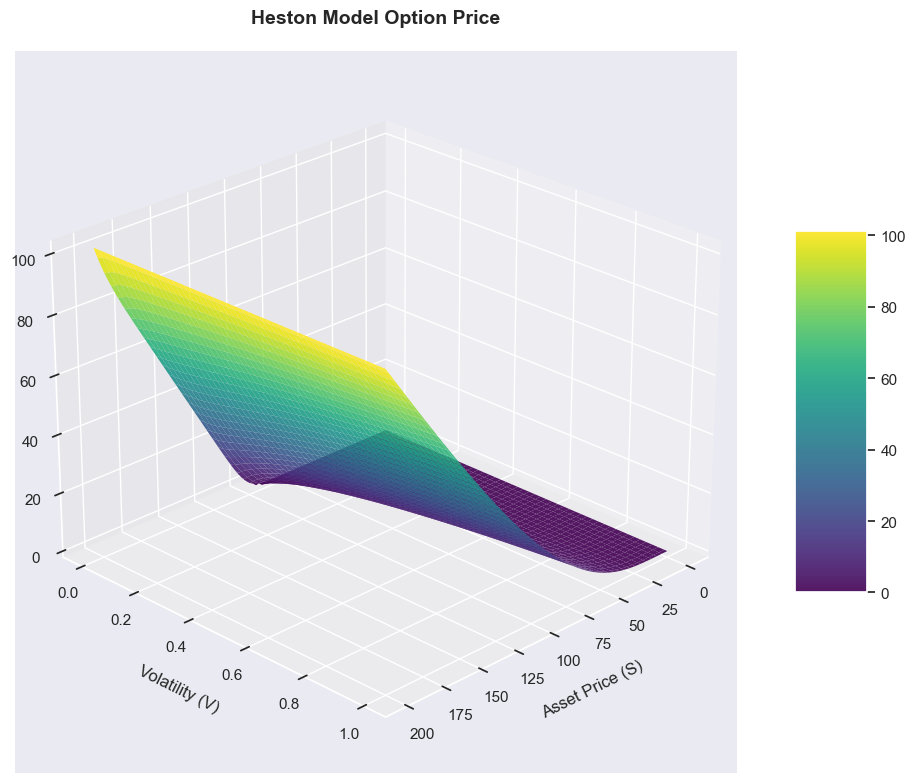

In [55]:
# Heston model parameters
kappa = 5
theta = 0.04
sigma = 0.15
rho = -0.9
r = 0.02
q = 0.05
K = 100
T = 1.0

NAS = 100 # number of asset steps
NVS = 100 # number of volatility steps
NTS = 200 # number of time steps

Smin = 0.0
Smax = 2 * K
Vmin = 0.0
Vmax = 1
tau_min = 0.0
tau_max = T

ds = (Smax - Smin) / (NAS - 1)
dv = (Vmax - Vmin) / (NVS - 1)
dt = (tau_max - tau_min) / NTS

S = np.linspace(Smin, Smax, NAS)
V = np.linspace(Vmin, Vmax, NVS)

# Here I am creating 2d grid from 1d spot and 1d volatility gird
S2d, V2d = np.meshgrid(S, V, indexing='ij')
N = NAS * NVS

S_flat = S2d.ravel(order='F')
V_flat = V2d.ravel(order='F')

DS, D2S, DV, D2V, DSV = build_derivatives_2d(NAS, NVS, ds, dv)

Sdiag = sp.sparse.diags(S_flat, 0)
S2diag = sp.sparse.diags(S_flat**2, 0)
Vdiag = sp.sparse.diags(V_flat, 0)
thetaV = sp.sparse.diags(theta - V_flat, 0)
I = sp.sparse.eye(N)

A0 = rho * sigma * Sdiag * Vdiag * DSV
A1 = (r - q) * Sdiag * DS + 0.5 * Vdiag * S2diag * D2S - 0.5 * r * I
A2 = kappa * thetaV * DV + 0.5 * sigma**2 * Vdiag * D2V- 0.5 * r * I

theta_ADI = 0.5 # 0.5 for Crank Nicholson
A_S_mat = I - theta_ADI * dt * A1
A_V_mat = I - theta_ADI * dt * A2
B_mat = I + (1 - theta_ADI) * dt * (A0 + A1 + A2)

A_S_mat = A_S_mat.tocsc()
A_V_mat = A_V_mat.tocsc()
B_mat = B_mat.tocsc()

A_S_factor = sp.sparse.linalg.splu(A_S_mat)
A_V_factor = sp.sparse.linalg.splu(A_V_mat)

U_terminal_2d = np.maximum(S2d - K, 0)
U = U_terminal_2d.ravel(order='F')

U_n = U.copy()
for n in range(NTS):
    Y0 = A_S_factor.solve(U_n)
    Y1 = sp.sparse.linalg.spsolve(I - 0.5 * dt * A1, Y0 - 0.5 * dt * A1 @ U_n)
    Y2 = sp.sparse.linalg.spsolve(I - 0.5 * dt * A2, Y1 - 0.5 * dt * A2 @ U_n)
    U_n = Y2

    t_current = T - (n + 1) * dt
    for j in range(NVS):
        idx_low  = 0 + j * NAS
        idx_high = (NAS - 1) + j * NAS
        U_n[idx_low] = 0.0
        U_n[idx_high] = Smax - K * np.exp(-r * (T - t_current))

    # At v = 0 - zero slope: U_n[i,0] = U_n[i,1]
    for i in range(NAS):
        idx_v0    = i + 0 * NAS
        idx_v1    = i + 1 * NAS
        U_n[idx_v0] = U_n[idx_v1]
    # At v = v_max - zero slope: U_n[i,NVS-1] = U_n[i,NVS-2]
    for i in range(NAS):
        idx_vm    = i + (NVS - 1) * NAS
        idx_vm_1  = i + (NVS - 2) * NAS
        U_n[idx_vm] = U_n[idx_vm_1]

U_final_2d = U_n.reshape((NAS, NVS), order='F')
plot_heston_simple(U_final_2d, S, V)
print(U_final_2d)
